In [1]:
# !pip install --quiet mlflow dagshub



# if CONFIG["is_submission"]:
!ls /kaggle/input/pyvips-python-and-deb-package
# intall the deb packages
!yes | dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb
# install the python wrapper
!pip install --quiet pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index

import pyvips



linux_packages	python_packages
Selecting previously unselected package autoconf.
(Reading database ... 107763 files and directories currently installed.)
Preparing to unpack .../autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package autopoint.
Preparing to unpack .../autopoint_0.19.8.1-10build1_all.deb ...
Unpacking autopoint (0.19.8.1-10build1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package bzip2-doc.
Preparing to unpack .../bzip2-doc_1.0.8-2_all.deb ...
Unpacking bzip2-doc (1.0.8-2) ...
Selecting previously unselected package debhelper.
Preparing to unpack .../debhelper_12.10ubuntu1_all.deb ...
Unpacking debhelper (12.10ubuntu1

In [2]:


import os
import gc
import cv2
import datetime
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
from skimage import io


# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
"""from cancer_utils_tiles import EarlyStopping, fetch_scheduler
from cancer_utils_tiles import CancerTilesDataset, TilesInferenceDataset
from cancer_utils_tiles import print_logged_info, get_dataloaders, data_transforms
from cancer_utils_tiles import get_train_file_path, get_test_file_path, get_or_create_experiment_id"""


# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
# warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
pd.set_option('display.max_rows', 200)

In [3]:
CONFIG = {
    "datetime_now": datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), 
    "fold": 1,
    "seed": 42,
    "img_size": 512,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}


In [4]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = "/kaggle/input/tiles-of-cancer-2048px-scale-0-25/"
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'


# 1. Get Data

In [14]:
def delete_tiles(directory_path):
    if os.path.isdir(directory_path):
        for filename in os.listdir(directory_path):
            if os.path.isfile(os.path.join(directory_path, filename)):
                os.remove(os.path.join(directory_path, filename))
                
def pad_tile_repeat(tile, h,w):
    tile_ = tile
    tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
    
    # Initialize a new tile with the desired size
    tile = np.zeros(tile_size, dtype=tile.dtype)
    
    # Determine the amount to pad on the bottom and right
    pad_y = h - tile_.shape[0]
    pad_x = w - tile_.shape[1]
    
    # Copy the original tile into the new tile
    tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_

    # Expand on the right by repeating the left side
    if pad_x > 0:
        tile[:, -pad_x:] = tile[:, :pad_x]

    # Expand on the bottom by repeating the top side
    if pad_y > 0:
        tile[-pad_y:, :] = tile[:pad_y, :]
    return tile

def pad_tile_continue(tile, h,w):
    tile_ = tile
    pad_y = h - tile_.shape[0]
    pad_x = w - tile_.shape[1]
    # Pad the tile using the 'edge' mode, which continues the border
    tile = np.pad(tile_, ((0, pad_y), (0, pad_x), (0, 0)), mode='edge')
    return tile
                
def pad_tile_mirroring(tile, h,w):
    tile_ = tile
    tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
    
    # Initialize a new tile with the desired size
    tile = np.zeros(tile_size, dtype=tile.dtype)
    
    # Determine the amount to pad on each side
    pad_y = h - tile_.shape[0]
    pad_x = w - tile_.shape[1]
    
    # Mirror the edges for padding
    # Vertical padding
    top = tile_[:pad_y, :] if pad_y > 0 else tile_
    bottom = tile_[-pad_y:, :] if pad_y > 0 else tile_
    vertical_padded = np.concatenate([top[::-1], tile_, bottom[::-1]], axis=0)
    
    # Horizontal padding
    left = vertical_padded[:, :pad_x] if pad_x > 0 else vertical_padded
    right = vertical_padded[:, -pad_x:] if pad_x > 0 else vertical_padded
    tile = np.concatenate([left[:, ::-1], vertical_padded, right[:, ::-1]], axis=1)
    return tile 


def extract_image_tiles(
    p_img, img_id, tmp_dir, size: int = 2048, scale: float = 0.5,
    drop_thr: float = 0.8, white_thr: int = 245, max_samples: int = 50
) -> list:
    # delete_tiles(tmp_dir)  # empty directory from previous images
    im = pyvips.Image.new_from_file(p_img)
    w = h = size
    # https://stackoverflow.com/a/47581978/4521646
    idxs = [(y, y + h, x, x + w) for y in range(0, im.height, h) for x in range(0, im.width, w)]
    # random subsample
    max_samples = max_samples if isinstance(max_samples, int) else int(len(idxs) * max_samples)
    random.seed(42)
    random.shuffle(idxs)
    images = []
    i = 0
    for y, y_, x, x_ in (idxs):
        i += 1
        img_path = f"{tmp_dir}/{img_id}_{str(i)}.png"
        # https://libvips.github.io/pyvips/vimage.html#pyvips.Image.crop
        tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]
        if (tile.shape[0] != h) & (tile.shape[1] != w):
            tile = im.crop(im.width - w, im.height-h, w, h).numpy()[..., :3]
        elif(tile.shape[0] != h):
            tile = im.crop(x, im.height-h, w, h).numpy()[..., :3]
        elif(tile.shape[1] != w):
            tile = im.crop(im.width - w, y, w, h).numpy()[..., :3]
            
            # tile = pad_tile_continue(tile, h,w)
            #tile_ = tile
            #tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
            #tile = np.zeros(tile_size, dtype=tile.dtype)
            #tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
        black_bg = np.sum(tile, axis=2) == 0
        tile[black_bg, :] = 255
        mask_bg = np.mean(tile, axis=2) > white_thr
        #if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
            #print(f"skip almost empty tile: {k:06}_{int(x_ / w)}-{int(y_ / h)}")
        #    continue
        # print(tile.shape, tile.dtype, tile.min(), tile.max())
        new_size = int(size * scale), int(size * scale)
        tile = Image.fromarray(tile).resize(new_size, Image.LANCZOS)
        tile.save(img_path)
        images.append(img_path)
        # need to set counter check as some empty tiles could be skipped earlier
        if len(images) >= max_samples:
            break
    return images


def extract_image_tiles(
    p_img, img_id, tmp_dir, size: int = 2048, scale: float = 0.5,
    drop_thr: float = 0.8, white_thr: int = 245, max_samples: int = 50
) -> list:
    im = pyvips.Image.new_from_file(p_img)
    w = h = size

    # Check if the image is smaller than the target size
    if im.width <= w and im.height <= h:
        # Handle the case where the image is smaller than the target size
        tile = im.numpy()[..., :3]
        if im.width < w:
            # Repeat the opposite side of the image to reach the target width
            repeat_w = np.tile(tile[:, :w - im.width, :], (1, (w - im.width) // im.width + 1, 1))
            tile = np.concatenate((tile, repeat_w[:, :w - im.width, :]), axis=1)
        if im.height < h:
            # Repeat the opposite side of the image to reach the target height
            repeat_h = np.tile(tile[:h - im.height, :, :], ((h - im.height) // im.height + 1, 1, 1))
            tile = np.concatenate((tile, repeat_h[:h - im.height, :, :]), axis=0)
    else:
        # Original logic for larger images
        idxs = [(y, y + h, x, x + w) for y in range(0, im.height, h) for x in range(0, im.width, w)]
        max_samples = max_samples if isinstance(max_samples, int) else int(len(idxs) * max_samples)
        random.seed(42)
        random.shuffle(idxs)
        tile = im.crop(idxs[0][2], idxs[0][0], min(w, im.width - idxs[0][2]), min(h, im.height - idxs[0][0])).numpy()[..., :3]

    # Common processing for the tile
    black_bg = np.sum(tile, axis=2) == 0
    tile[black_bg, :] = 255
    new_size = int(size * scale), int(size * scale)
    tile = Image.fromarray(tile).resize(new_size, Image.LANCZOS)

    # Save the tile
    img_path = f"{tmp_dir}/{img_id}_1.png"
    tile.save(img_path)

    return [img_path]


class TMATilesDataset(Dataset):

    def __init__(
        self,
        img_path: str,
        img_id: str = None,
        tmp_dir: str = None,
        size: int = 2048,
        scale: float = 0.25,
        white_thr: int = 225,
        thr_max_bg: float = 0.6,
        max_samples: int = 30,
        transforms = None,
        is_submission: bool = True,
    ):
        self.max_samples = max_samples
        self.white_thr = white_thr
        self.thr_max_bg = thr_max_bg
        self.is_submission = is_submission
        
        self.transforms = transforms
            # print(img_path)
        assert os.path.isfile(img_path)
        self.imgs = extract_image_tiles(
            img_path, img_id, tmp_dir, size=size, scale=scale,
            drop_thr=self.thr_max_bg, max_samples=max_samples)
        """    all_imgs = glob.glob(os.path.join(img_path, img_id, "*.png"))
            # Filter images based on background threshold
            self.imgs = []
            for img_path in all_imgs:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                black_bg = np.sum(img, axis=2) == 0
                img[black_bg, :] = 255
                mask_bg = np.mean(img, axis=2) > self.white_thr
                if np.sum(mask_bg) <= (np.prod(mask_bg.shape) * self.thr_max_bg):
                    self.imgs.append(img_path)  # Include this image
            self.imgs = self.imgs[:self.max_samples]"""
        print(f"Number of save tiles: {len(self.imgs)}")
            # print(self.imgs)

    def __getitem__(self, idx: int) -> tuple:
        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # filter background
        mask = np.sum(img, axis=2) == 0
        img[mask, :] = 255
        if np.max(img) < 1.5:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
        if self.transforms:
            img = self.transforms(image=img)["image"]
        return img

    def __len__(self) -> int:
        return len(self.imgs)

In [6]:
df_train = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
df_train["is_tma"] = df_train["is_tma"].astype(bool)
df_tma = df_train[df_train["is_tma"]==True]
df_tma.shape

(25, 5)

In [12]:
import matplotlib.image as mpimg

def plot_images(image_files):
    # Assuming image_files is a list of 25 image paths
    if len(image_files) != 25:
        raise ValueError("The list must contain exactly 25 image paths.")

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    
    # Iterate over the grid and add each image
    for idx, image_file in enumerate(image_files):
        row, col = idx // 5, idx % 5
        img = mpimg.imread(image_file)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # Turn off axis labels

    plt.tight_layout(pad=0.1)
    plt.show()

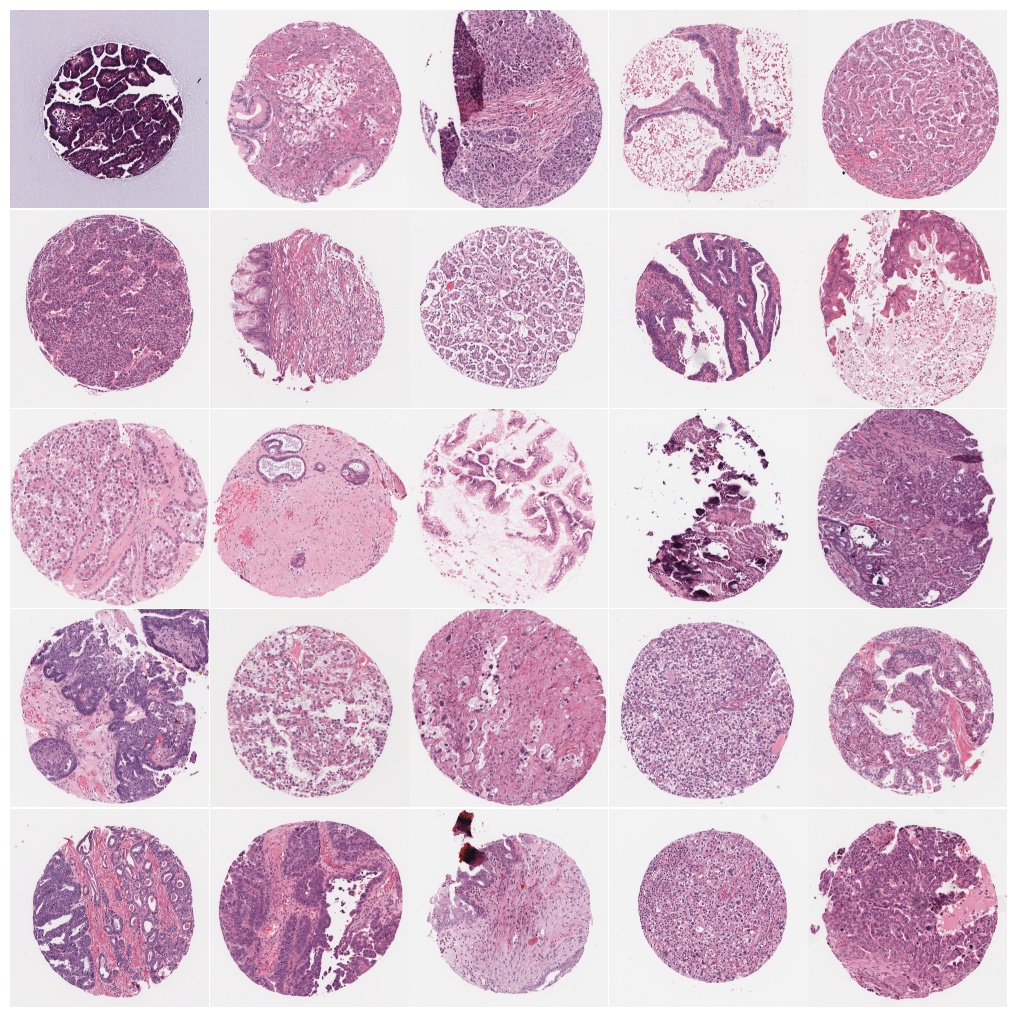

In [17]:
pth_list = ["/kaggle/input/UBC-OCEAN/train_images/"+str(img_id)+".png" for img_id in df_tma["image_id"]]
plot_images(pth_list)

In [31]:
img = mpimg.imread(pth_list[2])
img = np.array(img)
img.shape

(2964, 2964, 3)

In [32]:
# matplotlib.image.imsave('tma_0.png', img)
cv2.imwrite("tma_2.png", img)

True

In [23]:
im = Image.fromarray(img)
im.save("tom_0.png")

TypeError: Cannot handle this data type: (1, 1, 3), <f4

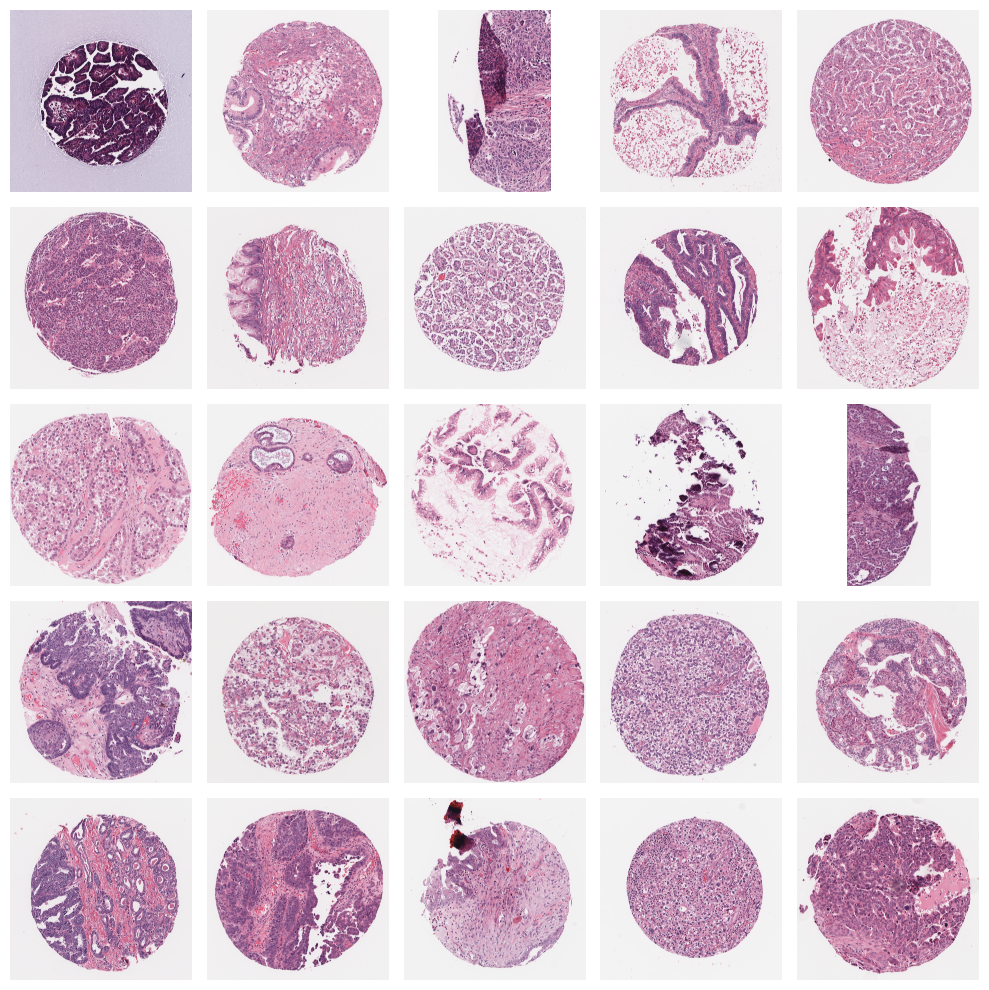

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_tissue_samples(image_path):
    # Read the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Compute the bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

# Apply the function to each image and plot
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for idx, image_file in enumerate(pth_list):
    cropped_image = crop_tissue_samples(image_file)
    ax = axes[idx // 5, idx % 5]
    ax.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()


In [7]:
df_tma

image_id label  image_width  image_height  is_tma
2          91  HGSC         3388          3388    True
37       4134    MC         2964          2964    True
76       8280  HGSC         2964          2964    True
83       9200    MC         3388          3388    True
112     13568  LGSC         2964          2964    True
149     17637  HGSC         2964          2964    True
176     21020    MC         3388          3388    True
236     29084  LGSC         3388          3388    True
263     31594    EC         3388          3388    True
288     35565    MC         2964          2964    True
299     36302    CC         3388          3388    True
302     36583  LGSC         3388          3388    True
305     36783    MC         2964          2964    True
309     37385  LGSC         3388          3388    True
350     40864  LGSC         2964          2964    True
354     41368    EC         3388          3388    True
355     41586    CC         2964          2964    True
361     42857    CC         2964          2964    True
375     44603    CC         3388          3388    True
399     47035    EC         2964          2964    True
409     48734    EC         3388          3388    True
423     50932  HGSC         2964          2964    True
452     53655    EC         3388          3388    True
484     57696    CC         3388          3388    True
510     61797  HGSC         3388          3388    True

In [15]:
from PIL import Image

dir_path = "UBC_TMA_tiles_4096px_scale0125_v3"
scale = 0.125
size = 4096

try:
    os.mkdir(dir_path)
except:
    pass
is_submission = True
for i, row in df_tma.iterrows():
    # row = dict(idx_row[1])
    img_id = str(row["image_id"])
    tmp_dir = dir_path+"/"+img_id
    os.mkdir(tmp_dir)
    print("Image ID: ", img_id)
    print("Save to: ", tmp_dir)
    dataset = TMATilesDataset(
        os.path.join("/kaggle/input/UBC-OCEAN/", "train_images", f"{img_id}.png"), img_id=img_id,
        size=size, scale=scale, max_samples=100,
    tmp_dir=tmp_dir)

Image ID:  91
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/91
Number of save tiles: 1
Image ID:  4134
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/4134
Number of save tiles: 1
Image ID:  8280
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/8280
Number of save tiles: 1
Image ID:  9200
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/9200
Number of save tiles: 1
Image ID:  13568
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/13568
Number of save tiles: 1
Image ID:  17637
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/17637
Number of save tiles: 1
Image ID:  21020
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/21020
Number of save tiles: 1
Image ID:  29084
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/29084
Number of save tiles: 1
Image ID:  31594
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/31594
Number of save tiles: 1
Image ID:  35565
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/35565
Number of save tiles: 1
Image ID:  36302
Save to:  UBC_TMA_tiles_4096px_scale0125_v3/36302
Number of save tiles: 1
Image ID:  

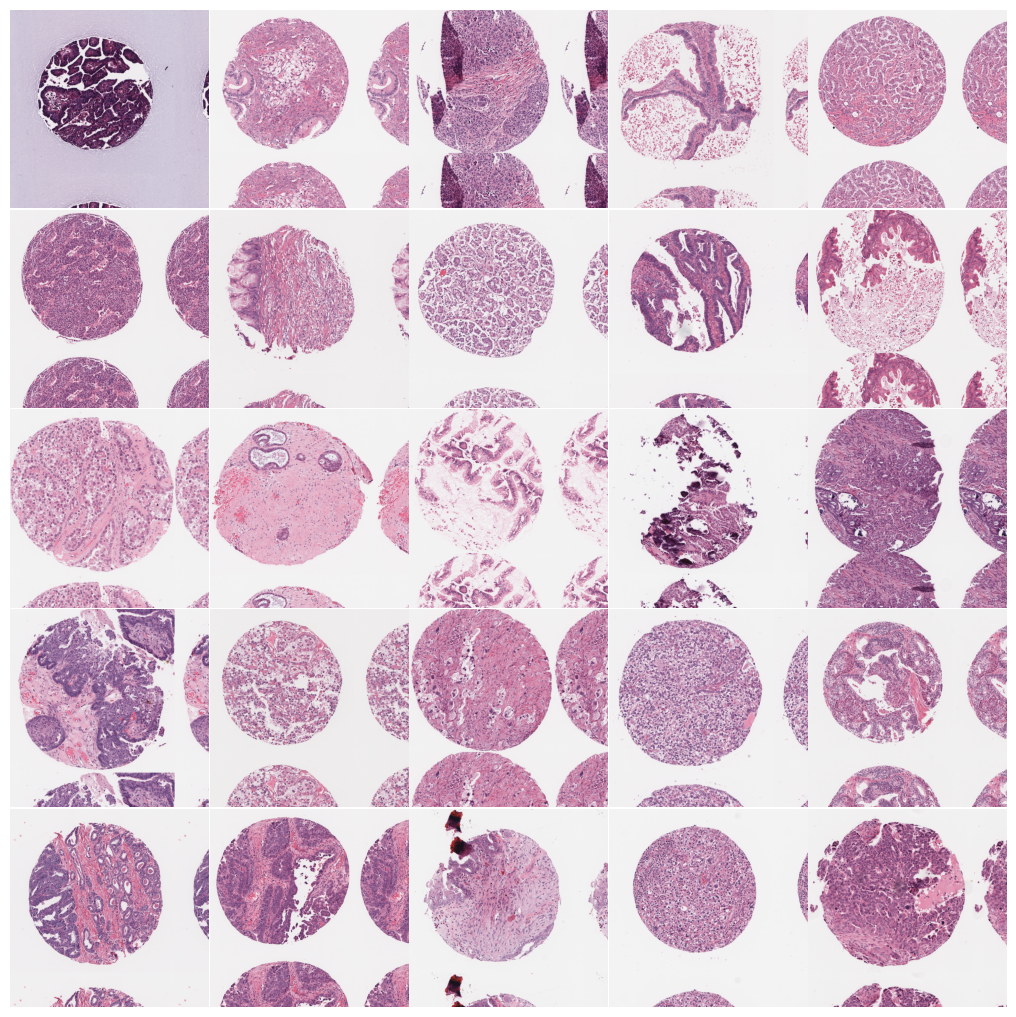

In [16]:
pth_list = ["/kaggle/working/UBC_TMA_tiles_4096px_scale0125_v3/"+str(img_id) + "/" + str(img_id) +  "_1.png" for img_id in df_tma["image_id"]]
plot_images(pth_list)

In [ ]:
len(train_loader_tma.dataset)

In [ ]:
train_loader_tma, valid_loader_tma, df_train_fold = get_dataloaders(df_train_min_tiles.head(1).copy(), TRAIN_DIR, CONFIG, data_transforms_orig, n_tiles=420, train_val_split=1)
print(len(train_loader_tma.dataset))
train_images = next(iter(train_loader_tma))
for i in range(len(train_loader_tma.dataset)):
    print(i)
    print(train_images["image"][i].shape)
plot_tiles(train_loader_tma, num_samples=len(train_loader_tma.dataset))

In [ ]:
import os
files_dir = dict()
for dirname, _, filenames in os.walk("/kaggle/working/UBC_TMA_tiles_1024px_scale05_v2/4134"):
    print(dirname)
    i = 0
    for filename in filenames:
        print(f"{dirname}/{filename}")
        im = Image.open(f"{dirname}/{filename}")
        print(im.size)
        # print(os.path.join(dirname, filename))
        i+=1
    files_dir[dirname] = i
    print(f"Number of tiles: {i}")

In [ ]:
def plot_images_from_folder(folder_path, N):
    # Get list of image file paths
    images = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('png', 'jpg', 'jpeg'))][:N]
    
    # Calculate grid size
    grid_size = int(N**0.5)
    if grid_size * grid_size < N:
        grid_size += 1

    # Create subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    # Plot each image
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(os.path.basename(img_path))

    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# plot_images_from_folder('/path/to/your/folder', 9)


In [ ]:
path = "/kaggle/working/UBC_TMA_tiles_1024px_scale05_v7/48734"
plot_images_from_folder(path, 16)

In [ ]:
path = "/kaggle/working/UBC_TMA_tiles_1024px_scale05/91"
plot_images_from_folder(path, 9)